In [1]:
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
# root_proj = Path("/Users/yk/Documents/Projects/Pre-PhD")
# root_proj = Path("/Users/VERTPOM-UPJV/Documents/Banque_de_l'energie_V2/Data_prediction_K/Pre-PhD")
root_proj = Path("/Users/alesk/Documents/Git-repo/Pre-PhD")
if str(root_proj/"src") not in sys.path:
    sys.path.append(str(root_proj/"src"))

In [12]:
year = 2022
file_name = root_proj / f"DATA_SYSTEM_LIDL/DTS_LIDL_{year}.csv"
dts1 = pd.read_csv(file_name, sep=";")
dts1

,Date,PV,EV
0,1/01/2022 1:00,0.0,0.68
1,1/01/2022 1:15,0.0,0.08
2,1/01/2022 1:30,0.0,0.08
3,1/01/2022 1:45,0.0,0.08
4,1/01/2022 2:00,0.0,0.08
...,...,...,...
34940,31/12/2022 0:00,0.0,0.12
34941,31/12/2022 0:15,0.0,0.08
34942,31/12/2022 0:30,0.0,0.08
34943,31/12/2022 0:45,0.0,0.08


In [18]:
temp = pd.read_csv(root_proj / f"DATA_SYSTEM_LIDL/Temperature/orly_{year}_hourly_weather.csv", sep=",")
temp["Date"]= pd.to_datetime(temp["time"])
temp[:8739]

C:\Users\alesk\AppData\Local\Temp\ipykernel_16428\1560297681.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  temp["Date"]= pd.to_datetime(temp["time"])


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Date
0,2022-01-01 01:00:00+01:00,9.7,9.6,99.0,0.0,0.0,160.0,5.4,11.0,1026.5,NaN,5.0,2022-01-01 01:00:00+01:00
1,2022-01-01 02:00:00+01:00,9.8,9.7,99.0,0.0,NaN,190.0,3.6,14.8,1026.6,NaN,5.0,2022-01-01 02:00:00+01:00
2,2022-01-01 03:00:00+01:00,9.3,9.2,99.0,0.0,NaN,160.0,3.6,13.0,1026.5,NaN,5.0,2022-01-01 03:00:00+01:00
3,2022-01-01 04:00:00+01:00,8.9,8.9,100.0,0.0,0.0,180.0,5.4,11.0,1026.3,NaN,5.0,2022-01-01 04:00:00+01:00
4,2022-01-01 05:00:00+01:00,8.3,8.3,100.0,0.2,NaN,120.0,5.4,14.8,1026.2,NaN,5.0,2022-01-01 05:00:00+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8734,2022-12-30 23:00:00+01:00,14.6,12.6,88.0,0.2,NaN,210.0,29.5,40.8,1009.0,NaN,7.0,2022-12-30 23:00:00+01:00
8735,2022-12-31 00:00:00+01:00,14.8,12.5,86.0,0.0,NaN,210.0,27.7,44.5,1009.5,NaN,7.0,2022-12-31 00:00:00+01:00
8736,2022-12-31 01:00:00+01:00,14.5,12.5,88.0,0.2,0.0,210.0,29.5,65.0,1009.8,NaN,7.0,2022-12-31 01:00:00+01:00
8737,2022-12-31 02:00:00+01:00,15.0,12.3,84.0,0.2,NaN,210.0,33.5,50.0,1010.1,NaN,7.0,2022-12-31 02:00:00+01:00


In [23]:
dts1["Date"] = pd.to_datetime(dts1['Date'],dayfirst=True)
dts1["Date"] = dts1["Date"].dt.floor("H")
pv_hourly = (
    dts1
    .groupby("Date", as_index=False)["PV"]
    .mean()
)

pv_hourly

C:\Users\alesk\AppData\Local\Temp\ipykernel_16428\927398658.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dts1["Date"] = dts1["Date"].dt.floor("H")


,Date,PV
0,2022-01-01 01:00:00,0.0
1,2022-01-01 02:00:00,0.0
2,2022-01-01 03:00:00,0.0
3,2022-01-01 04:00:00,0.0
4,2022-01-01 05:00:00,0.0
...,...,...
8732,2022-12-30 21:00:00,0.0
8733,2022-12-30 22:00:00,0.0
8734,2022-12-30 23:00:00,0.0
8735,2022-12-31 00:00:00,0.0


In [24]:
dts = pv_hourly
dts['temp'] = temp[:len(dts)].temp 
dts

,Date,PV,temp
0,2022-01-01 01:00:00,0.0,9.7
1,2022-01-01 02:00:00,0.0,9.8
2,2022-01-01 03:00:00,0.0,9.3
3,2022-01-01 04:00:00,0.0,8.9
4,2022-01-01 05:00:00,0.0,8.3
...,...,...,...
8732,2022-12-30 21:00:00,0.0,14.3
8733,2022-12-30 22:00:00,0.0,14.5
8734,2022-12-30 23:00:00,0.0,14.6
8735,2022-12-31 00:00:00,0.0,14.8


In [25]:
dts['hour'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.hour
# dts['minute'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.minute
dts['dayofyear'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.dayofyear
dts['month'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.month
dts['dayofweek'] = pd.to_datetime(dts['Date'],dayfirst=True).dt.dayofweek
dts['hour_sin'] = np.sin(2*np.pi*dts['hour']/24)
dts['hour_cos'] = np.cos(2*np.pi*dts['hour']/24)
dts['doy_sin'] = np.sin(2*np.pi*dts['dayofyear']/365)
dts['doy_cos'] = np.cos(2*np.pi*dts['dayofyear']/365)
dts['dow_sin'] = np.sin(2*np.pi*dts['dayofweek']/7)
dts['dow_cos'] = np.cos(2*np.pi*dts['dayofweek']/7)

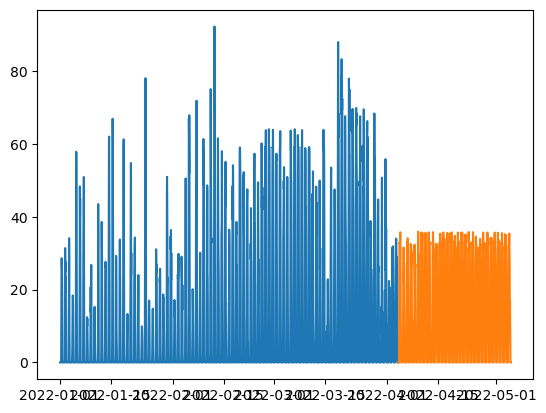

In [26]:
initial = dts.index[dts['Date'] == '4/04/2022 1:00'][0]
final = dts.index[dts['Date'] == '5/05/2022 1:00'][0]

df_train = dts.iloc[:initial]
df_test = dts.iloc[initial:final]
plt.plot(df_train.Date,df_train['PV'], label='Train')
plt.plot(df_test.Date,df_test['PV'], label='Test')

In [36]:
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterRecursive(
    regressor = RandomForestRegressor(random_state=42),
    lags = int(24*2), # use previous one day
    window_features = RollingFeatures(stats=['max','std'], window_sizes=int(24))
)

C:\Users\alesk\AppData\Local\Temp\ipykernel_16428\1514661857.py:5: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster = ForecasterRecursive(


In [37]:
import joblib as jb
import json

output_dir = root_proj / "checkpoints" / "point01_pv"

if not (output_dir / "log_pv.json").is_file(): # first train
    output_dir.mkdir(parents=True, exist_ok=True)
    # training
    forecaster.fit(y=df_train['PV'],exog=df_train[['hour_sin','hour_cos','doy_sin','doy_cos','dow_sin','dow_cos','temp']], store_in_sample_residuals=True)
    # residuals = forecaster.in_sample_residuals  # 查看训练残差
    # save model
    jb.dump(forecaster, output_dir/"model.joblib")
    # log
    log = {
        "metadata": {
            "description": "recursive random forest regresion",
            "lags": int((60/15)*24*7),
            "window_features": {
                "type": "rolling",
                "stats": ["mean"],
                "window_size": int((60/15)*24*7)
            },
            "freq": "15min"
        },
        # "residuals": forecaster.in_sample_residuals
    }
    # save log
    with open(output_dir/"log.json", "w") as f:
        json.dump(log, f, indent=2)
    print("End of training")
else:
    # 加载模型 | load model
    forecaster = jb.load(output_dir/"model.joblib")
    # load log
    with open(output_dir/"log.json", "r") as f:
        log = json.load(f)
    print("Loaded")

End of training


In [38]:
yhat_test = forecaster.predict(steps=len(df_test), exog=df_test[['hour_sin','hour_cos','doy_sin','doy_cos','dow_sin','dow_cos','temp']])

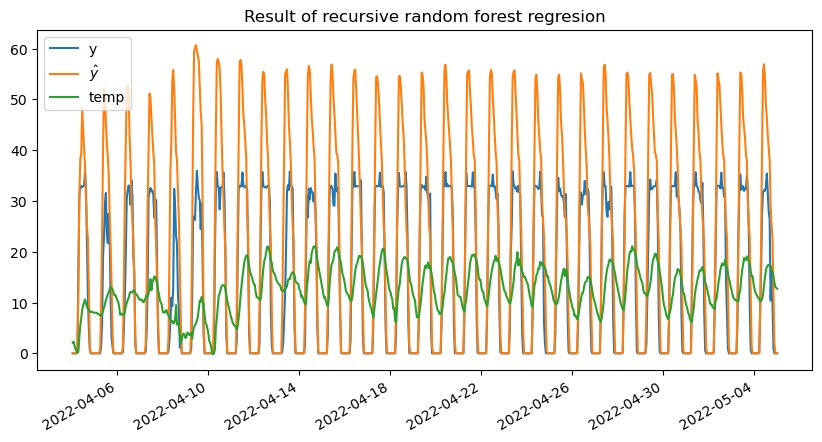

In [40]:
# Save and display the plot
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Result of recursive random forest regresion")
# ax.plot(df_train['Date'],df_train['PV'])
ax.plot(df_test['Date'], df_test['PV'], label='y')
ax.plot(df_test['Date'], yhat_test, label=r'$\hat{y}$')
ax.plot(df_test['Date'],df_test['temp'], label='temp')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

# optional: minor ticks every 6 hours
# ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

ax.legend()

fig.autofmt_xdate() # for rotation
fig.savefig(output_dir / "prediction_test.png", dpi=300, bbox_inches='tight')
plt.show()